## Eye State Classification from EEG


### Introduction


### Data Prep



In [1]:
# setting the random seed for reproducibility
import random
seed=42
random.seed(seed)

In [2]:
# import libraries 
import itertools
import requests
import os.path
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

### Load the Data

In [3]:
# check if data file exists locally
if not os.path.isfile('EEG Eye State.arff'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
    r = requests.get(url, allow_redirects=True)
    open('EEG Eye State.arff', 'wb').write(r.content)

# read data from local csv file
#df = pd.read_csv("EEGEyeState.csv", header=None)

# read data from local arff file
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

In [4]:
# reject NaN entries
df.dropna()

# insert columns names
df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

# remove outliers
df1 = df[df.loc[:, df.columns != 'eyeDetection'].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

# define data samples
X = df1.iloc[0:, 0:14].values

# standardize data
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_short = min_max_scaler.fit_transform(X)

# define target
y_short = df1.iloc[0:,14].values.astype(int)

unique, counts = np.unique(y_short, return_counts=True)
print(dict(zip(unique, counts)))

print(df.shape)
print(X_short,X_short.shape,'\n\n',
      y_short,y_short.shape)

{0: 8172, 1: 6720}
(14980, 15)
[[0.43315296 0.42978053 0.53914831 ... 0.44283486 0.52808589 0.51187141]
 [0.41794246 0.41065428 0.56628488 ... 0.43715177 0.51965054 0.48535451]
 [0.4280718  0.41915944 0.57527166 ... 0.4514152  0.50842166 0.49930648]
 ...
 [0.26227399 0.35319255 0.289163   ... 0.3171384  0.4072796  0.36402948]
 [0.2859641  0.35742439 0.31624082 ... 0.36856474 0.41993263 0.3947075 ]
 [0.29609344 0.38086545 0.36745962 ... 0.4085692  0.4241503  0.3947075 ]] (14892, 14) 

 [0 0 0 ... 1 1 1] (14892,)


### Model



In [5]:
# full dataset parameters

# define model parameters
samples = X_short.shape[0]  # how many trials of eeg data
n_features = X_short.shape[1]  # how many channels of eeg in each sample
time_steps = 1 # how many ms was each sample run for

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
sss.get_n_splits(X_short, y_short)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_short, y_short):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_short[train_index], X_short[test_index]
    y_train, y_test = y_short[train_index], y_short[test_index]
    
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], time_steps)

X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], time_steps)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, TerminateOnNaN

model = Sequential()
model.add(Bidirectional(SimpleRNN(28, return_sequences=True, 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               input_shape=(time_steps, n_features))))
model.add(Bidirectional(SimpleRNN(28, input_shape=(time_steps, n_features), 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(SimpleRNN(28, input_shape=(time_steps, n_features),
              recurrent_regularizer=l1_l2(0.0001, 0.0001))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

terminate_NaN = TerminateOnNaN()

history = model.fit(X_train, y_train, validation_split=0.25, 
                    batch_size=28, epochs=1000, verbose=1, 
                    callbacks=[early_stop, terminate_NaN])

Train on 8934 samples, validate on 2979 samples
Epoch 1/1000
8934/8934 [==============================] - 7s 789us/step - loss: 0.7005 - acc: 0.5730 - val_loss: 0.6533 - val_acc: 0.6029
Epoch 2/1000
8934/8934 [==============================] - 4s 396us/step - loss: 0.6614 - acc: 0.5950 - val_loss: 0.6552 - val_acc: 0.6130
Epoch 3/1000
8934/8934 [==============================] - 4s 395us/step - loss: 0.6567 - acc: 0.6081 - val_loss: 0.6976 - val_acc: 0.5814
Epoch 4/1000
8934/8934 [==============================] - 4s 393us/step - loss: 0.6542 - acc: 0.6145 - val_loss: 0.6643 - val_acc: 0.5606
Epoch 5/1000
8934/8934 [==============================] - 4s 398us/step - loss: 0.6494 - acc: 0.6164 - val_loss: 0.6544 - val_acc: 0.6244
Epoch 6/1000
8934/8934 [==============================] - 4s 392us/step - loss: 0.6483 - acc: 0.6287 - val_loss: 0.6574 - val_acc: 0.5948
Epoch 7/1000
8934/8934 [==============================] - 4s 403us/step - loss: 0.6442 - acc: 0.6325 - val_loss: 0.7029 - va

8934/8934 [==============================] - 4s 413us/step - loss: 0.4739 - acc: 0.7841 - val_loss: 0.4109 - val_acc: 0.8171
Epoch 60/1000
8934/8934 [==============================] - 4s 423us/step - loss: 0.4750 - acc: 0.7829 - val_loss: 0.4214 - val_acc: 0.8100
Epoch 61/1000
8934/8934 [==============================] - 4s 399us/step - loss: 0.4708 - acc: 0.7846 - val_loss: 0.4209 - val_acc: 0.8150
Epoch 62/1000
8934/8934 [==============================] - 3s 388us/step - loss: 0.4656 - acc: 0.7870 - val_loss: 0.4131 - val_acc: 0.8124
Epoch 63/1000
8934/8934 [==============================] - 4s 392us/step - loss: 0.4667 - acc: 0.7906 - val_loss: 0.4240 - val_acc: 0.8087
Epoch 64/1000
8934/8934 [==============================] - 4s 393us/step - loss: 0.4672 - acc: 0.7890 - val_loss: 0.4271 - val_acc: 0.8090
Epoch 65/1000
8934/8934 [==============================] - 4s 408us/step - loss: 0.4683 - acc: 0.7836 - val_loss: 0.4265 - val_acc: 0.8093
Epoch 66/1000
8934/8934 [================

Epoch 118/1000
8934/8934 [==============================] - 4s 444us/step - loss: 0.4367 - acc: 0.8083 - val_loss: 0.3809 - val_acc: 0.8288
Epoch 119/1000
8934/8934 [==============================] - 4s 440us/step - loss: 0.4381 - acc: 0.8034 - val_loss: 0.4112 - val_acc: 0.8147
Epoch 120/1000
8934/8934 [==============================] - 4s 443us/step - loss: 0.4390 - acc: 0.8099 - val_loss: 0.4320 - val_acc: 0.8083
Epoch 121/1000
8934/8934 [==============================] - 4s 422us/step - loss: 0.4300 - acc: 0.8124 - val_loss: 0.3643 - val_acc: 0.8375
Epoch 122/1000
8934/8934 [==============================] - 4s 395us/step - loss: 0.4330 - acc: 0.8095 - val_loss: 0.3838 - val_acc: 0.8271
Epoch 123/1000
8934/8934 [==============================] - 4s 410us/step - loss: 0.4364 - acc: 0.8070 - val_loss: 0.3656 - val_acc: 0.8345
Epoch 124/1000
8934/8934 [==============================] - 4s 396us/step - loss: 0.4308 - acc: 0.8105 - val_loss: 0.3676 - val_acc: 0.8385
Epoch 125/1000
8934/

8934/8934 [==============================] - 4s 393us/step - loss: 0.4108 - acc: 0.8167 - val_loss: 0.3475 - val_acc: 0.8483
Epoch 177/1000
8934/8934 [==============================] - 3s 389us/step - loss: 0.4199 - acc: 0.8148 - val_loss: 0.3478 - val_acc: 0.8476
Epoch 178/1000
8934/8934 [==============================] - 3s 389us/step - loss: 0.4144 - acc: 0.8162 - val_loss: 0.3349 - val_acc: 0.8513
Epoch 179/1000
8934/8934 [==============================] - 4s 392us/step - loss: 0.4184 - acc: 0.8196 - val_loss: 0.3316 - val_acc: 0.8540
Epoch 180/1000
8934/8934 [==============================] - 4s 406us/step - loss: 0.4143 - acc: 0.8200 - val_loss: 0.3515 - val_acc: 0.8446
Epoch 181/1000
8934/8934 [==============================] - 4s 393us/step - loss: 0.4112 - acc: 0.8206 - val_loss: 0.3386 - val_acc: 0.8506
Epoch 182/1000
8934/8934 [==============================] - 3s 389us/step - loss: 0.4082 - acc: 0.8211 - val_loss: 0.3339 - val_acc: 0.8567
Epoch 183/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 400us/step - loss: 0.3907 - acc: 0.8331 - val_loss: 0.3322 - val_acc: 0.8614
Epoch 235/1000
8934/8934 [==============================] - 4s 393us/step - loss: 0.3978 - acc: 0.8293 - val_loss: 0.3429 - val_acc: 0.8520
Epoch 236/1000
8934/8934 [==============================] - 4s 396us/step - loss: 0.3995 - acc: 0.8224 - val_loss: 0.3182 - val_acc: 0.8600
Epoch 237/1000
8934/8934 [==============================] - 4s 401us/step - loss: 0.3902 - acc: 0.8325 - val_loss: 0.3116 - val_acc: 0.8634
Epoch 238/1000
8934/8934 [==============================] - 4s 400us/step - loss: 0.3937 - acc: 0.8278 - val_loss: 0.3139 - val_acc: 0.8671
Epoch 239/1000
8934/8934 [==============================] - 4s 399us/step - loss: 0.3963 - acc: 0.8270 - val_loss: 0.3279 - val_acc: 0.8583
Epoch 240/1000
8934/8934 [==============================] - 3s 389us/step - loss: 0.3863 - acc: 0.8346 - val_loss: 0.3318 - val_acc: 0.8597
Epoch 241/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 453us/step - loss: 0.3846 - acc: 0.8375 - val_loss: 0.2996 - val_acc: 0.8755
Epoch 293/1000
8934/8934 [==============================] - 4s 426us/step - loss: 0.3759 - acc: 0.8413 - val_loss: 0.3007 - val_acc: 0.8708
Epoch 294/1000
8934/8934 [==============================] - 4s 440us/step - loss: 0.3695 - acc: 0.8433 - val_loss: 0.3140 - val_acc: 0.8738
Epoch 295/1000
8934/8934 [==============================] - 4s 406us/step - loss: 0.3768 - acc: 0.8384 - val_loss: 0.2981 - val_acc: 0.8758
Epoch 296/1000
8934/8934 [==============================] - 4s 394us/step - loss: 0.3710 - acc: 0.8390 - val_loss: 0.3160 - val_acc: 0.8610
Epoch 297/1000
8934/8934 [==============================] - 4s 398us/step - loss: 0.3743 - acc: 0.8411 - val_loss: 0.3013 - val_acc: 0.8728
Epoch 298/1000
8934/8934 [==============================] - 4s 398us/step - loss: 0.3768 - acc: 0.8400 - val_loss: 0.3009 - val_acc: 0.8741
Epoch 299/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 387us/step - loss: 0.3685 - acc: 0.8392 - val_loss: 0.2887 - val_acc: 0.8842
Epoch 351/1000
8934/8934 [==============================] - 4s 398us/step - loss: 0.3693 - acc: 0.8418 - val_loss: 0.2815 - val_acc: 0.8805
Epoch 352/1000
8934/8934 [==============================] - 3s 391us/step - loss: 0.3552 - acc: 0.8484 - val_loss: 0.2885 - val_acc: 0.8781
Epoch 353/1000
8934/8934 [==============================] - 4s 405us/step - loss: 0.3677 - acc: 0.8425 - val_loss: 0.2947 - val_acc: 0.8771
Epoch 354/1000
8934/8934 [==============================] - 4s 407us/step - loss: 0.3748 - acc: 0.8332 - val_loss: 0.2994 - val_acc: 0.8761
Epoch 355/1000
8934/8934 [==============================] - 4s 402us/step - loss: 0.3630 - acc: 0.8416 - val_loss: 0.2815 - val_acc: 0.8872
Epoch 356/1000
8934/8934 [==============================] - 4s 405us/step - loss: 0.3591 - acc: 0.8464 - val_loss: 0.2968 - val_acc: 0.8778
Epoch 357/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 399us/step - loss: 0.3492 - acc: 0.8545 - val_loss: 0.2870 - val_acc: 0.8788
Epoch 409/1000
8934/8934 [==============================] - 4s 398us/step - loss: 0.3615 - acc: 0.8458 - val_loss: 0.2921 - val_acc: 0.8812
Epoch 410/1000
8934/8934 [==============================] - 4s 397us/step - loss: 0.3576 - acc: 0.8491 - val_loss: 0.2830 - val_acc: 0.8845
Epoch 411/1000
8934/8934 [==============================] - 4s 407us/step - loss: 0.3472 - acc: 0.8509 - val_loss: 0.2773 - val_acc: 0.8815
Epoch 412/1000
8934/8934 [==============================] - 4s 400us/step - loss: 0.3615 - acc: 0.8492 - val_loss: 0.2739 - val_acc: 0.8889
Epoch 413/1000
8934/8934 [==============================] - 4s 414us/step - loss: 0.3563 - acc: 0.8496 - val_loss: 0.2809 - val_acc: 0.8815
Epoch 414/1000
8934/8934 [==============================] - 4s 396us/step - loss: 0.3498 - acc: 0.8544 - val_loss: 0.2684 - val_acc: 0.8916
Epoch 415/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 440us/step - loss: 0.3465 - acc: 0.8576 - val_loss: 0.2664 - val_acc: 0.8966
Epoch 467/1000
8934/8934 [==============================] - 4s 456us/step - loss: 0.3457 - acc: 0.8556 - val_loss: 0.2643 - val_acc: 0.8902
Epoch 468/1000
8934/8934 [==============================] - 3s 377us/step - loss: 0.3417 - acc: 0.8564 - val_loss: 0.2697 - val_acc: 0.8909
Epoch 469/1000
8934/8934 [==============================] - 3s 392us/step - loss: 0.3455 - acc: 0.8561 - val_loss: 0.2813 - val_acc: 0.8862
Epoch 470/1000
8934/8934 [==============================] - 4s 396us/step - loss: 0.3527 - acc: 0.8506 - val_loss: 0.2792 - val_acc: 0.8849
Epoch 471/1000
8934/8934 [==============================] - 4s 404us/step - loss: 0.3553 - acc: 0.8502 - val_loss: 0.2715 - val_acc: 0.8926
Epoch 472/1000
8934/8934 [==============================] - 4s 403us/step - loss: 0.3397 - acc: 0.8601 - val_loss: 0.2747 - val_acc: 0.8839
Epoch 473/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 351us/step - loss: 0.3422 - acc: 0.8563 - val_loss: 0.2569 - val_acc: 0.8916
Epoch 525/1000
8934/8934 [==============================] - 3s 362us/step - loss: 0.3402 - acc: 0.8571 - val_loss: 0.2836 - val_acc: 0.8828
Epoch 526/1000
8934/8934 [==============================] - 3s 358us/step - loss: 0.3448 - acc: 0.8537 - val_loss: 0.2644 - val_acc: 0.8916
Epoch 527/1000
8934/8934 [==============================] - 3s 352us/step - loss: 0.3286 - acc: 0.8630 - val_loss: 0.2576 - val_acc: 0.8879
Epoch 528/1000
8934/8934 [==============================] - 3s 361us/step - loss: 0.3390 - acc: 0.8574 - val_loss: 0.2596 - val_acc: 0.8896
Epoch 529/1000
8934/8934 [==============================] - 3s 364us/step - loss: 0.3322 - acc: 0.8589 - val_loss: 0.2775 - val_acc: 0.8798
Epoch 530/1000
8934/8934 [==============================] - 3s 367us/step - loss: 0.3411 - acc: 0.8565 - val_loss: 0.2784 - val_acc: 0.8849
Epoch 531/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 316us/step - loss: 0.3319 - acc: 0.8642 - val_loss: 0.2629 - val_acc: 0.8929
Epoch 583/1000
8934/8934 [==============================] - 3s 319us/step - loss: 0.3250 - acc: 0.8658 - val_loss: 0.2569 - val_acc: 0.8939
Epoch 584/1000
8934/8934 [==============================] - 3s 305us/step - loss: 0.3450 - acc: 0.8522 - val_loss: 0.2701 - val_acc: 0.8875
Epoch 585/1000
8934/8934 [==============================] - 3s 322us/step - loss: 0.3263 - acc: 0.8639 - val_loss: 0.2450 - val_acc: 0.9033
Epoch 586/1000
8934/8934 [==============================] - 3s 314us/step - loss: 0.3260 - acc: 0.8657 - val_loss: 0.2476 - val_acc: 0.9020
Epoch 587/1000
8934/8934 [==============================] - 3s 310us/step - loss: 0.3292 - acc: 0.8599 - val_loss: 0.2412 - val_acc: 0.9027
Epoch 588/1000
8934/8934 [==============================] - 3s 312us/step - loss: 0.3292 - acc: 0.8632 - val_loss: 0.2534 - val_acc: 0.8926
Epoch 589/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 311us/step - loss: 0.3176 - acc: 0.8671 - val_loss: 0.2641 - val_acc: 0.8899
Epoch 641/1000
8934/8934 [==============================] - 3s 322us/step - loss: 0.3259 - acc: 0.8657 - val_loss: 0.2559 - val_acc: 0.8953
Epoch 642/1000
8934/8934 [==============================] - 3s 323us/step - loss: 0.3190 - acc: 0.8669 - val_loss: 0.2522 - val_acc: 0.8936
Epoch 643/1000
8934/8934 [==============================] - 3s 311us/step - loss: 0.3259 - acc: 0.8618 - val_loss: 0.2433 - val_acc: 0.9030
Epoch 644/1000
8934/8934 [==============================] - 3s 308us/step - loss: 0.3241 - acc: 0.8651 - val_loss: 0.2373 - val_acc: 0.9063
Epoch 645/1000
8934/8934 [==============================] - 3s 312us/step - loss: 0.3171 - acc: 0.8693 - val_loss: 0.2488 - val_acc: 0.9013
Epoch 646/1000
8934/8934 [==============================] - 3s 306us/step - loss: 0.3117 - acc: 0.8711 - val_loss: 0.2489 - val_acc: 0.8973
Epoch 647/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 306us/step - loss: 0.3098 - acc: 0.8767 - val_loss: 0.2326 - val_acc: 0.9080
Epoch 699/1000
8934/8934 [==============================] - 3s 310us/step - loss: 0.3151 - acc: 0.8704 - val_loss: 0.2419 - val_acc: 0.9023
Epoch 700/1000
8934/8934 [==============================] - 3s 311us/step - loss: 0.3142 - acc: 0.8728 - val_loss: 0.2357 - val_acc: 0.9063
Epoch 701/1000
8934/8934 [==============================] - 3s 314us/step - loss: 0.3188 - acc: 0.8715 - val_loss: 0.2411 - val_acc: 0.9033
Epoch 702/1000
8934/8934 [==============================] - 3s 309us/step - loss: 0.3082 - acc: 0.8717 - val_loss: 0.2389 - val_acc: 0.9043
Epoch 703/1000
8934/8934 [==============================] - 3s 311us/step - loss: 0.3101 - acc: 0.8705 - val_loss: 0.2398 - val_acc: 0.9070
Epoch 704/1000
8934/8934 [==============================] - 3s 309us/step - loss: 0.3112 - acc: 0.8744 - val_loss: 0.2366 - val_acc: 0.9104
Epoch 705/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 310us/step - loss: 0.3065 - acc: 0.8743 - val_loss: 0.2327 - val_acc: 0.9080
Epoch 757/1000
8934/8934 [==============================] - 3s 318us/step - loss: 0.3081 - acc: 0.8734 - val_loss: 0.2298 - val_acc: 0.9121
Epoch 758/1000
8934/8934 [==============================] - 3s 310us/step - loss: 0.3071 - acc: 0.8743 - val_loss: 0.2324 - val_acc: 0.9063
Epoch 759/1000
8934/8934 [==============================] - 3s 315us/step - loss: 0.3146 - acc: 0.8695 - val_loss: 0.2355 - val_acc: 0.9033
Epoch 760/1000
8934/8934 [==============================] - 3s 317us/step - loss: 0.3040 - acc: 0.8733 - val_loss: 0.2468 - val_acc: 0.9040
Epoch 761/1000
8934/8934 [==============================] - 3s 324us/step - loss: 0.3052 - acc: 0.8725 - val_loss: 0.2391 - val_acc: 0.9040
Epoch 762/1000
8934/8934 [==============================] - 3s 313us/step - loss: 0.3058 - acc: 0.8731 - val_loss: 0.2288 - val_acc: 0.9137
Epoch 763/1000
8934/8934 [=========

In [8]:
score = model.evaluate(X_test, y_test, batch_size=28)
score

2979/2979 [==============================] - 0s 80us/step


[0.23030424361767765, 0.9100369243423344]

In [9]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 91.00%


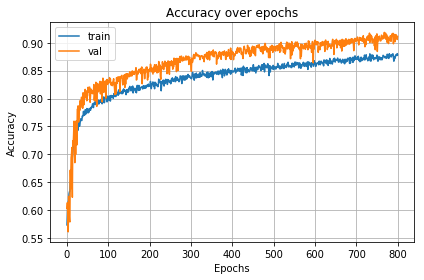

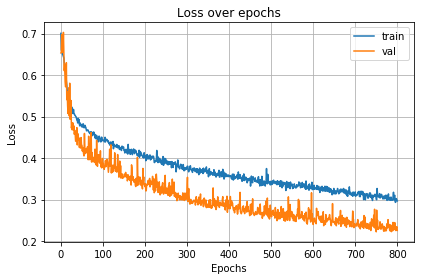

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.grid(True, which='both', axis='both')

# plt.minorticks_on()
plt.tight_layout()

plt.legend()
plt.show()

plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.legend()
plt.show()

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [13]:
from keras.models import load_model

model.save('eeg_eye_state_model_brnn.h5')  # creates a HDF5 file 'my_model.h5'

# model = load_model('eeg_eye_state_model_brnn.h5')


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict_classes(X_test)
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.926
Recall: 0.870
F1: 0.897


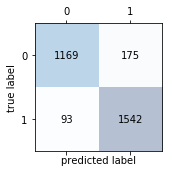

In [15]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
#print(confmat)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

ROC AUC: 0.906
Accuracy: 0.910


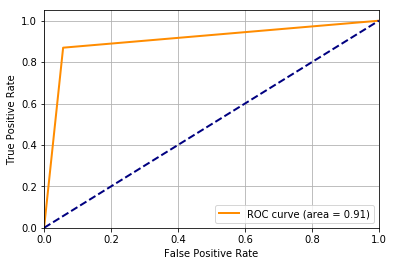

In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

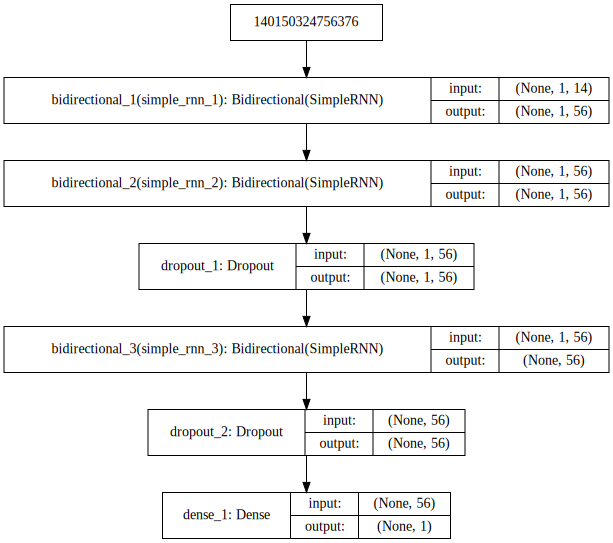

In [17]:
from keras.utils import plot_model
# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


In [18]:
from sklearn.metrics import classification_report
target_names = ['eye opened', 'eye closed']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

              precision    recall  f1-score   support

  eye opened      0.898     0.943     0.920      1635
  eye closed      0.926     0.870     0.897      1344

   micro avg      0.910     0.910     0.910      2979
   macro avg      0.912     0.906     0.909      2979
weighted avg      0.911     0.910     0.910      2979



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.86')

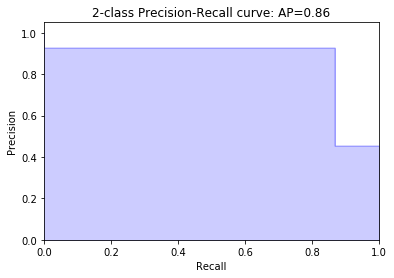

In [19]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 56)             2408      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 56)             4760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 56)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 56)                4760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 57        
Total params: 11,985
Trainable params: 11,985
Non-trainable params: 0
_________________________________________________________________
